In [1]:
import numpy as np
import h5py
from datetime import datetime

In [2]:
import os

In [3]:
os.environ["MKL_NUM_THREADS"] = "10" 
os.environ["NUMEXPR_NUM_THREADS"] = "10" 
os.environ["OMP_NUM_THREADS"] = "10" 

In [35]:
def nbrs(cur, x, y):

    layer = x * y
    xl = (cur - 1) % x + x * (cur // x)
    xr = (cur + 1) % x + (cur // x) * x
    yl = (cur - x) % layer + layer * (cur // layer)
    yr = (cur + x) % layer + layer * (cur // layer)
    return xl, xr, yl, yr

def nbrs2(cur, x, y):

    layer = x * y
    lx,ly = nbrs((cur - 1) % x + x * (cur // x), x, y)[2:]
    rx,ry = nbrs((cur + 1) % x + x * (cur // x), x, y)[2:]
    return lx, ly, rx, ry


def make_mtx(x, y, t1, t2 = 0):
    N = x * y
    m = np.zeros((N, N))
    for n in range(N):
        ns = nbrs(n, x, y)
        m[n, [ns]] = t1
        ns = nbrs2(n, x, y)
        m[n, [ns]] = t2
    return m


fermi = lambda e, T: 1. / (np.exp(e / T) + 1)


def recompute_par(evals, evecs, mu_0, N, U, T):
    
    indx = np.where(evals >= 0.0)[0]
    delta = np.abs(U) * np.sum(evecs[:N, indx] * np.conj(evecs[N:, indx]) * (1 - 2 * fermi(evals[indx], T)), axis=1)  # sum(uv(1 - 2f))
    n_avg = 2 * np.sum(evecs[N:, indx] ** 2 * (1 - fermi(evals[indx], T)) +
                       evecs[:N, indx] ** 2 * fermi(evals[indx], T), axis=1)  # n = 2sum(v^2 * (1-f) + u^2*f)     
    mu = mu_0 + 0.5 * np.abs(U) * n_avg
    return (delta, mu, n_avg)


def construct_H(M, N, U, V, mu, delta):
    
    h1 = np.concatenate((M - (mu - V) * np.eye(N), delta * np.eye(N)), axis=0)
    h2 = np.concatenate((delta * np.eye(N), -M + (mu - V) * np.eye(N)), axis=0)
    return np.concatenate((h1, h2), axis=1)


def coordinate(number, a, b):
    return np.array([number % a, number // b])


def distance(i, j, a, b):
    dx, dy = coordinate(i, a, b) - coordinate(j, a, b)
    if np.abs(dx) > a/2:
        dx = a - np.abs(dx)
    if np.abs(dy) > b/2:
        dy = b - np.abs(dy)
    return np.linalg.norm([dx,dy])
    #return coordinate(i, a, b) - coordinate(j, a, b))

def dd(n, x, y, delta):
    data = {}
    for i in range(n):
        for j in range(n):
            rij = distance(i, j, x, y)
            if rij not in data:
                data[rij] = [delta[i] * delta[j]]
            else:
                data[rij].append(delta[i] * delta[j])
    return data

def write(file, e, v, delta, n):
    with h5py.File(file, 'a') as f:
        f.create_dataset("evals", data=e)
        f.create_dataset("evecs", data=v)
        f.create_dataset("delta", data=delta)
        f.create_dataset("avg", data=n)

def run(U, M, N, V, delta, T, max_iterations, tol, mu_0, r, l, point, file):
    
    avg = 0
    mstep = 0
    while np.abs(point - avg) > tol and mstep < max_iterations:
        mstep += 1
        #print('mu',mu_0, end = ' :')
        print(f"{np.round(np.abs(point - avg), 4):^7.4f}", end = ' : ')
        mu = mu_0 + 0.00005 * np.abs(U) * np.random.sample(N)
        atol = 10
        step = 0
        while atol > 1e-08 and step < max_iterations:
            
            H = construct_H(M, N, U, V, mu, delta)
            e, v = np.linalg.eigh(H)
            delta, mu_new, avg = recompute_par(e, v, mu_0, N, U, T)
            atol = np.linalg.norm(mu_new - mu) / np.sum(np.abs(delta))
            mu = mu_new
            step += 1 
            #print(f'<atol>={atol}' )
        avg_dist = avg
        avg = np.sum(avg)/N
        if point - avg > 0:
            l = mu_0
        else:
            r = mu_0
        mu_0 = 0.5 * (r + l)

    if mstep < max_iterations:
        write(file, e, v, delta, avg_dist)
    return mu_0

In [36]:
t1 = 1
t2 = -0.3
M = make_mtx(24, 24, t1, t2)
N = M.shape[0]
U = 0.8


In [39]:
filling = 0.15
distr = np.zeros(N)
for i in range(N):
    if np.random.rand() < filling:
        distr[i] = 1#2 * np.random.rand() - 1

In [40]:
distr.nonzero()[0].shape[0] / N

0.1545138888888889

In [41]:
import matplotlib.pyplot as plt

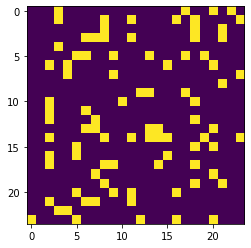

In [42]:
plt.imshow(distr.reshape(24,24))

In [ ]:
V0 = 0.05
mu_0 = 2
dirp = f"NNN/data_V{V0:.2f}"
V = V0 * distr
for T in np.arange(10, 301, 10):
    print('T = {:^3.0f}'.format(T), end=' : ')
    delta = - np.abs(U) * np.random.sample(N)
    max_iterations =  100
    tol = 5e-03
    
    r = 4
    l =-4
    point = 0.85
    
    if not os.path.isdir(dirp):
        os.mkdir(dirp)
    file = f"{dirp}/U{U}_point{point}_T{T}"
    t1 = datetime.now()
    mu_0 = run(U, M, N, V, delta, T / 11604, max_iterations, tol, mu_0, r, l, point, file)
    t2 = datetime.now()
#         data = dd(24 ** 2, 24, 24, delta)
    print(':: Loop time {}'.format((t2 - t1).total_seconds()))

T = 10  : 0.8500  : 

<ipython-input-35-bff15a0d0f8f>:29: RuntimeWarning: overflow encountered in exp
  fermi = lambda e, T: 1. / (np.exp(e / T) + 1)


1.1465  : 0.2354  : 0.2646  : 

### Corrections

In [12]:
Tout = np.arange(130, 301, 10)

In [13]:
dirp = f"NNN/data_V{V0:.2f}"
for T in Tout:
    file = f"{dirp}/U{U}_point{point}_T{T}"
    os.remove(file)

In [14]:
mu_0 = 1
V = V0 * distr
for T in Tout:
    print('T = {:^3.0f}'.format(T), end=' : ')
    delta = - np.abs(U) * np.random.sample(N)
    max_iterations =  1000
    tol = 5e-03
    
    r = 10
    l =-10
    point = 0.85
    
    if not os.path.isdir(dirp):
        os.mkdir(dirp)
    file = f"{dirp}/U{U}_point{point}_T{T}"
    t1 = datetime.now()
    mu_0 = run(U, M, N, V, delta, T / 11604, max_iterations, tol, mu_0, r, l, point, file)
    t2 = datetime.now()
#         data = dd(24 ** 2, 24, 24, delta)
    print(':: Loop time {}'.format((t2 - t1).total_seconds()))

T = 130 : 0.8500  : 0.5254  : 

<ipython-input-4-97ceb71233bd>:29: RuntimeWarning: overflow encountered in exp
  fermi = lambda e, T: 1. / (np.exp(e / T) + 1)


0.8500  : 0.4294  : 0.2179  : 0.0176  : 0.1189  : 0.0545  : 0.0207  : :: Loop time 40.047507
T = 140 : 0.8500  : 0.0067  : 0.9139  : 0.6402  : 0.3912  : 0.2253  : 0.1280  : 0.0615  : 0.0298  : 0.0109  : :: Loop time 78.040972
T = 150 : 0.8500  : :: Loop time 22.441938
T = 160 : 0.8500  : 0.9139  : 0.8496  : 0.5017  : 0.0331  : 0.4859  : 0.2067  : 0.0734  : 0.0164  : 0.0084  : :: Loop time 44.118918
T = 170 : 0.8500  : :: Loop time 19.383769
T = 180 : 0.8500  : 0.8500  : 0.7041  : 0.3658  : 0.3847  : 0.1392  : 0.0596  : 0.0500  : :: Loop time 26.868754
T = 190 : 0.8500  : 0.0283  : 0.8500  : 0.8500  : 0.6080  : 0.3017  : 0.1116  : 0.0404  : :: Loop time 44.47329
T = 200 : 0.8500  : 0.0099  : 0.8500  : 0.8500  : 0.6227  : 0.3219  : 0.1320  : 0.0568  : 0.0221  : :: Loop time 77.515966
T = 210 : 0.8500  : :: Loop time 16.909524
T = 220 : 0.8500  : 0.8500  : 0.7039  : 0.3659  : 0.3847  : 0.1388  : 0.0598  : 0.0500  : :: Loop time 26.672209
T = 230 : 0.8500  : 0.0282  : 0.8500  : 0.8500  : 0

In [93]:
mu_0

-0.45883122086524963